<a target="_blank" href="https://colab.research.google.com/github/corl-team/xland-minigrid/blob/main/examples/walkthrough.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# XLand-MiniGrid Walkthrough

**Last updated: 01.12.2023**

Welcome to the walkthrough the XLand-MiniGrid library. This notebook will showcase our environments and bechmarks APIs, explaning the details and our motivations. It will also provide vectorization and multi-device parallelization examples. For full baselines training demo see our notebooks with standalone PPO implementations.

> ⚠️ Ensure you select a GPU from `Runtime > Change runtime type`. ⚠️

> ⚠️ Colab TPU runtime is not compatible with new JAX versions (> 0.4.0). Please, use kaggle notebooks if you want to use TPUs. There is no quick way to open notebook from github in kaggle (like colab badge above), so you will need to manually upload it. ⚠️

> 🔥 Instances with multiple T4 gpus are available on Kaggle for free! Multi-gpu can speed up examples with `pmap`. 🔥

### Install dependencies

We install JAX with GPU support and some other utilities, it may take a while... 

In [2]:
# jax is already installed on the colab, uncomment only if needed
# !pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install xminigrid
# !pip install "xminigrid[baselines] @ git+https://github.com/corl-team/xland-minigrid.git"

In [3]:
# general utilities
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np

import timeit
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm


def show_img(img, dpi=32):
    plt.figure(dpi=dpi)
    plt.axis("off")
    plt.imshow(img)

## Environments

As we noted in the README, currently, there are a lot of new JAX-based environments appearing, each offering its own variant of API. Initially, we tried to reuse Jumaji, but it turned out that its design is not suitable for meta learning. The Gymnax design appeared to be more appropriate, but unfortunately it is not actively supported and often departs from the idea that parameters should only be contained in env_params. Furthermore, splitting timestep into multiple entities seems suboptimal to us, as it complicates many things, such as envpool or dm-env style auto reset, where the reset occurs on the next step (we need access to done of previous step).

Therefore, we decided that we would make a minimal interface that would cover just our needs without the goal of making it generic. The core of our library is interface independent, and we plan to switch to the new one when/if a better design becomes available (e.g. when stable Gymnasium FuncEnv is released).

### API

Most users who are familiar with other popular JAX-based environments (such as Gymnax or Jumnaji), will find that the interface is very similar. On the high level, current API combines DeepMind Environment and gymnax interfaces.


All our environments follow the structure of the following base class:
```python
class EnvParams(struct.PyTreeNode):
    ...


class Environment:
    def default_params(self, **kwargs) -> EnvParams:
        return EnvParams().replace(**kwargs)

    def num_actions(self, params: EnvParams) -> int:
        ...

    def observation_shape(self, params: EnvParams) -> tuple[int, int, int]:
        ...

    def time_limit(self, params: EnvParams) -> int:
        ...

    def _generate_problem(self, params: EnvParams, key: jax.Array) -> State:
        ...

    def reset(self, params: EnvParams, key: jax.Array) -> TimeStep:
        ...

    def step(self, params: EnvParams, timestep: TimeStep, action: int) -> TimeStep:
        ...

    def render(self, params: EnvParams, timestep: TimeStep) -> jax.Array:
        ...    
```

with main methods being `reset` and `step` which are fully jit-compatible. Overall the environment instance itself is stateless. The environment state as well as step info is stored in the `TimeStep` container:

```python
class TimeStep(struct.PyTreeNode):
    # hidden environment state, such as grid, agent, goal, etc 
    state: State

    # similar to the dm_env enterface
    step_type: StepType
    reward: jax.Array
    discount: jax.Array
    observation: jax.Array
```

Let's create simple environment with the help of `make`, jit-compile the `reset` and `step`, step the environment and visualize the resuling state:

Observation shape: (7, 7, 2)
Num actions: 6
TimeStep shapes: TimeStep(state=State(key=(2,), step_num=(), grid=(8, 8, 2), agent=AgentState(position=(2,), direction=(), pocket=(2,)), goal_encoding=(5,), rule_encoding=(1, 7), carry=EnvCarry()), step_type=(), reward=(), discount=(), observation=(7, 7, 2))


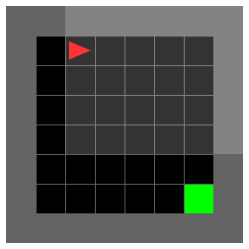

In [4]:
import xminigrid

key = jax.random.PRNGKey(0)
key, reset_key = jax.random.split(key)

# to list available environments: xminigrid.registered_environments()
env, env_params = xminigrid.make("MiniGrid-Empty-8x8")
print("Observation shape:", env.observation_shape(env_params))
print("Num actions:", env.num_actions(env_params))

# fully jit-compatible step and reset methods
timestep = jax.jit(env.reset)(env_params, reset_key)
timestep = jax.jit(env.step)(env_params, timestep, action=0)

print("TimeStep shapes:", jtu.tree_map(jnp.shape, timestep))

show_img(env.render(env_params, timestep), dpi=64)

### Registry

Similar to the other libraries we provide convenient registy utilities, such that users can get all registered environments or `register` new environments (or variations of the already provided) for the further usage with `make`. Registration is not compatible with jit, so creating environments has to happen outside. However, you can create them inside jit with the original classes from `xminigrid.envs` directly. 

In [5]:
# first four registered standard environments
xminigrid.registered_environments()[:4]

('XLand-MiniGrid-R1-9x9',
 'XLand-MiniGrid-R1-13x13',
 'XLand-MiniGrid-R1-17x17',
 'XLand-MiniGrid-R2-9x9')

Let's register new example environment. You can provide arbitrary environment arguments, which will be provided to the `env.default_params` upon creating inside `make`. Given that the environment itself does not contain parameters and states, one can realise that registration actually just provides a convenient way to get default parameters for different setups. Users can freely change these `env_params` after creation. However, we do not advice this outside of the meta-RL applications. Better to explicitly register new parameters variations.

In [6]:
xminigrid.register(
    id="MiniGrid-EmptyRandom-9x9",
    entry_point="xminigrid.envs.minigrid.empty:EmptyRandom",
    height=9,
    width=9,
)

We enforce some limitations on the environment names for the consistency. All names should start from the `XLand-MiniGrid` (for meta-RL) or `MiniGrid` (for just RL). This is just a convention.

In [8]:
# xminigrid.register(
#     id="Some_name",
#     entry_point="xminigrid.envs.minigrid.empty:EmptyRandom",
#     height=9,
#     width=9,
# )

ValueError: Invalid id format. Should start from XLand-MiniGrid or MiniGrid.

All environment parameters can be provided to the `make` and will overwrite the default ones. This is equivalent to the `env_params.replace(view_size=3)` afther creation.

Params: EnvParams(height=9, width=9, view_size=3, render_mode='rgb_array')


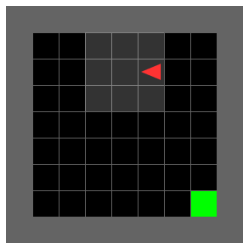

In [9]:
env, env_params = xminigrid.make("MiniGrid-EmptyRandom-9x9", view_size=3)
timestep = jax.jit(env.reset)(env_params, reset_key)

print("Params:", env_params)
show_img(env.render(env_params, timestep), dpi=64)

### Scan through entire episodes

Main advantage of jit-compatible environments is ability to scan through the entire episodes avoiding python. We provide here a small example of such scanned rollout with random policy. However, this template is quite general and we use it in our baselines implementations. With such design it is extremely easy to vectorize and parallelize it with `vmap` and `pmap` transformations. We also use `xminigrid.wrappers.GymAutoResetWrapper` here to auto-reset the environment. Two auto-reset styles are available: `GymAutoResetWrapper` and `DmEnvAutoResetWrapper`. With gym style environment will reset on the same step with `done`, while with dm_env style environment will reset on the next step after done (action will be ignored).

For the examples on how to rollout until `done` see rollout function used for evaluation during baselines training.

In [10]:
from xminigrid.wrappers import GymAutoResetWrapper


# alternatively users can provide step_fn and reset_fn instead
# of the closure, but in whis way it is simpler to use after the creation
def build_rollout(env, env_params, num_steps):
    def rollout(rng):
        def _step_fn(carry, _):
            rng, timestep = carry
            rng, _rng = jax.random.split(rng)
            action = jax.random.randint(
                _rng, shape=(), minval=0, maxval=env.num_actions(env_params)
            )

            timestep = env.step(env_params, timestep, action)
            return (rng, timestep), timestep

        rng, _rng = jax.random.split(rng)

        timestep = env.reset(env_params, _rng)
        rng, transitions = jax.lax.scan(
            _step_fn, (rng, timestep), None, length=num_steps
        )
        return transitions

    return rollout


env, env_params = xminigrid.make("MiniGrid-EmptyRandom-8x8")
# do not forget to use auto reset wrapper!
env = GymAutoResetWrapper(env)

# jiting the entire rollout
rollout_fn = jax.jit(build_rollout(env, env_params, num_steps=1000))

# first execution will compile
transitions = rollout_fn(jax.random.PRNGKey(0))

print("Transitions shapes: \n", jtu.tree_map(jnp.shape, transitions))

Transitions shapes: 
 TimeStep(state=State(key=(1000, 2), step_num=(1000,), grid=(1000, 8, 8, 2), agent=AgentState(position=(1000, 2), direction=(1000,), pocket=(1000, 2)), goal_encoding=(1000, 5), rule_encoding=(1000, 1, 7), carry=EnvCarry()), step_type=(1000,), reward=(1000,), discount=(1000,), observation=(1000, 7, 7, 2))


### Visualization

Rollouts can be visualized as usuall, just record all timesteps, then render them with `env.render`:

In [11]:
images = []

for i in trange(1000):
    timestep = jtu.tree_map(lambda x: x[i], transitions)
    images.append(env.render(env_params, timestep))

imageio.mimsave("example_rollout.mp4", images, fps=32, format="mp4")

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/afs219/.conda/envs/hurms_env/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [12]:
from IPython.display import Video

Video("example_rollout.mp4", embed=True)

### Vectorization

We can easily vectorize the rollout with `jax.vmap`:

In [13]:
vmap_rollout = jax.jit(jax.vmap(build_rollout(env, env_params, num_steps=1000)))
rngs = jax.random.split(jax.random.PRNGKey(0), num=1024)

vmap_transitions = vmap_rollout(rngs)

print("Transitions shapes: \n", jtu.tree_map(jnp.shape, vmap_transitions))

Transitions shapes: 
 TimeStep(state=State(key=(1024, 1000, 2), step_num=(1024, 1000), grid=(1024, 1000, 8, 8, 2), agent=AgentState(position=(1024, 1000, 2), direction=(1024, 1000), pocket=(1024, 1000, 2)), goal_encoding=(1024, 1000, 5), rule_encoding=(1024, 1000, 1, 7), carry=EnvCarry()), step_type=(1024, 1000), reward=(1024, 1000), discount=(1024, 1000), observation=(1024, 1000, 7, 7, 2))


After that we cat just as easily parallelize among devices available with `jax.pmap`:

In [14]:
# pmap will jit
pmap_rollout = jax.pmap(jax.vmap(build_rollout(env, env_params, 1000)))
pmap_rngs = rngs.reshape(jax.local_device_count(), 1024 // jax.local_device_count(), -1)

pmap_transitions = pmap_rollout(pmap_rngs)
print("Transitions shapes: \n", jtu.tree_map(jnp.shape, pmap_transitions))

Transitions shapes: 
 TimeStep(state=State(key=(4, 256, 1000, 2), step_num=(4, 256, 1000), grid=(4, 256, 1000, 8, 8, 2), agent=AgentState(position=(4, 256, 1000, 2), direction=(4, 256, 1000), pocket=(4, 256, 1000, 2)), goal_encoding=(4, 256, 1000, 5), rule_encoding=(4, 256, 1000, 1, 7), carry=EnvCarry()), step_type=(4, 256, 1000), reward=(4, 256, 1000), discount=(4, 256, 1000), observation=(4, 256, 1000, 7, 7, 2))


### Measuring FPS

Knowing all of the above we can make a small benchmark to measure FPS for a random policy. At the beginning we will make a scanned rollout, then vectorize and parallelize it.

In [15]:
def build_benchmark(env_id, num_envs, timesteps):
    env, env_params = xminigrid.make(env_id)
    env = GymAutoResetWrapper(env)

    def benchmark_fn(key):
        def _step_fn(timestep, action):
            new_timestep = jax.vmap(env.step, in_axes=(None, 0, 0))(
                env_params, timestep, action
            )
            return new_timestep, None

        key, actions_key = jax.random.split(key)
        keys = jax.random.split(key, num=num_envs)
        actions = jax.random.randint(
            actions_key,
            shape=(timesteps, num_envs),
            minval=0,
            maxval=env.num_actions(env_params),
        )
        timestep = jax.vmap(env.reset, in_axes=(None, 0))(env_params, keys)
        timestep = jax.lax.scan(_step_fn, timestep, actions, unroll=1)[0]
        return timestep

    return benchmark_fn


# see https://stackoverflow.com/questions/56763416/what-is-diffrence-between-number-and-repeat-in-python-timeit
# on why we divide by num_iter
def timeit_benchmark(benchmark_fn, num_iter=1, num_repeat=10):
    benchmark_fn().state.grid.block_until_ready()
    times = timeit.repeat(
        lambda: benchmark_fn().state.grid.block_until_ready(),
        number=num_iter,
        repeat=num_repeat,
    )
    times = np.array(times) / num_iter
    elapsed_time = np.max(times)

    return elapsed_time

In [16]:
num_devices = jax.local_device_count()
envs_range = [512, 1024, 2048, 4096, 8192]
print("Num devices for pmap:", num_devices)

vmap_stats, pmap_stats = [], []
for num_envs in tqdm(envs_range):
    # building vmap for vectorization benchmarking
    benchmark_fn_vmap = build_benchmark("MiniGrid-EmptyRandom-8x8", num_envs, 1024)
    benchmark_fn_vmap = jax.jit(benchmark_fn_vmap)
    # building pmap for multi-gpu benchmarking (each doing (num_envs / num_devices) vmaps)
    benchmark_fn_pmap = build_benchmark(
        "MiniGrid-EmptyRandom-8x8", num_envs // num_devices, 1024
    )
    benchmark_fn_pmap = jax.pmap(benchmark_fn_pmap)

    key = jax.random.PRNGKey(0)
    pmap_keys = jax.random.split(key, num=num_devices)

    elapsed_time = timeit_benchmark(jax.tree_util.Partial(benchmark_fn_vmap, key))
    vmap_fps = (1024 * num_envs) / elapsed_time

    elapsed_time = timeit_benchmark(jax.tree_util.Partial(benchmark_fn_pmap, pmap_keys))
    pmap_fps = (1024 * num_envs) / elapsed_time

    vmap_stats.append(vmap_fps)
    pmap_stats.append(pmap_fps)

Num devices for pmap: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Note that the actual values may differ from the reported in the paper, as the default colab GPU is less powerfull that A100 used in the main experiments. But even on the one T4 GPU users can expect to get ~**10M** steps per second (and ~**25M** with two T4 GPUs on kaggle notebooks with `pmap`)!! However, compared to A100 scaling will saturate a lot earilier with respect to number of parallel environments.

In [17]:
for n, vfps, pfps in zip(envs_range, vmap_stats, pmap_stats):
    print(f"{n} envs. vmap fps: {vfps}, pmap fps: {pfps}")

512 envs. vmap fps: 3477663.0657091686, pmap fps: 3747757.9253307288
1024 envs. vmap fps: 6773189.371951341, pmap fps: 6979673.377063845
2048 envs. vmap fps: 13318948.144679466, pmap fps: 13805124.622236941
4096 envs. vmap fps: 24028508.00223916, pmap fps: 26014537.003561992
8192 envs. vmap fps: 40290084.49358166, pmap fps: 52968833.187259585


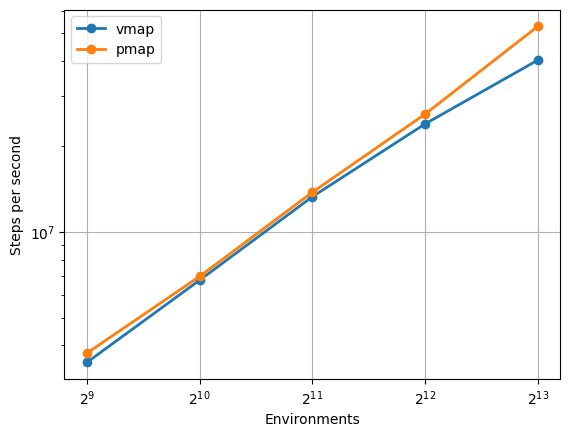

In [18]:
plt.plot(envs_range, vmap_stats, "o-", label="vmap", linewidth=2.0)
plt.plot(envs_range, pmap_stats, "o-", label="pmap", linewidth=2.0)
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.grid()
plt.ylabel("Steps per second")
plt.xlabel("Environments")
plt.legend(loc="upper left");

## Rules & Goals

In XLand-MiniGrid, the system of rules and goals is the cornerstone of the emergent complexity and diversity. In the original MiniGrid some environments have dynamic goals, but the dynamics are never changed. To train and evaluate highly adaptive agents, we need to be able to change the dynamics in non-trivial ways.

**Rules** are the functions that can change the environment state in some deterministic way according to the given conditions. **Goals** are similar to rules, except they do not change the state, they only test conditions. 

This section examples are a bit low level, but they will help you to understand how rules and goals work under the hood.

In [ ]:
# utils for the demonstation
from xminigrid.core.grid import room
from xminigrid.types import AgentState
from xminigrid.core.actions import take_action
from xminigrid.core.constants import Tiles, Colors, TILES_REGISTRY
from xminigrid.rendering.rgb_render import render

# rules and goals
from xminigrid.core.goals import check_goal, AgentNearGoal
from xminigrid.core.rules import check_rule, AgentNearRule

Let's setup simple one-room environment. We will spawn one yellow ball near the agent. After that we will perform an action moving agent one tile foward with the help of `take_action`. This function returns udpated grid, agent and also some position of interest (usually the position of object that somehow changed), which is needed for goals and rules checking. 

In [ ]:
# for testing
grid = room(6, 6)
grid = grid.at[1, 1].set(TILES_REGISTRY[Tiles.BALL, Colors.YELLOW])

agent = AgentState(position=jnp.array((1, 3)), direction=3)

# taking move forward action
move_forward_action = jnp.asarray(0)
new_grid, new_agent, position = take_action(grid, agent, move_forward_action)

show_img(render(grid, agent), dpi=64)
show_img(render(new_grid, new_agent), dpi=64)

As we described above, goals are functions (actually classes in code) that take some arguments and validates come conditions. For example, let's create `AgentNearGoal` that checks that agent is near some object (only horizontally and vertically, not diagonally). This goal requires us only to specify the tile and after that we can use it.

For efficiency and compatibility with JAX, all goals (or rules) have vector representations that encode all the necessary information from which the goal (or rule) can be accurately recreated. First index is always an **ID** of the rule or goal. It is usually followed by arguments sequentially. 

Why is that? The main purpose is so that goals and rules arguments can be changed between resets and thus be dynamic. It is also important for us to be able to store them in a compact form during benchmark generation, as there could be millions of them. At the same time, we can decode them with `jax.lax.switch` (that what `check_goal` does) every time they are needed, which actually has a small overhead (from our limited testing). The alternative would be to first decode the whole million rulesets into classes when loading the benchmark, which would take a long time. And lastly, during training we will sample different rulesets inside the jit, which means that all shapes or pytree structures should stay the same, which is not true for different set of rulesets as classes. Encoding as a vector allows us to bring everything to the same shape.


In [ ]:
goal = AgentNearGoal(tile=TILES_REGISTRY[Tiles.BALL, Colors.YELLOW])
goal_encoding = goal.encode()

print("Goal:", goal)
print("Goal encoding:", goal_encoding)
print("Goal decoding:", AgentNearGoal.decode(goal_encoding))

Goals can be checked directly, but usually you will see `check_goal` in the codebase, as it works with encodings. But why does it accept such bizarre arguments? It is done, again, for efficiency. Many rules and goals don't need to be checked on every step, and most only need to be checked for any particular location that has changed in any way after the action. For example, `AgentNearGoal` can be checked only after the `move_forward` action.

In [ ]:
(
    goal(new_grid, new_agent, move_forward_action, position)
    == check_goal(goal_encoding, new_grid, new_agent, move_forward_action, position)
)

How to get the class instance from it's **ID** in the encoding? There seems to be only one path, and that's the one we're using:
```python
def check_goal(encoding, grid, agent, action, position):
    check = jax.lax.switch(
        encoding[0],
        (
            # empty goal first, we use them as paddings during benchmark generation
            lambda: EmptyGoal.decode(encoding)(grid, agent, action, position),
            lambda: AgentHoldGoal.decode(encoding)(grid, agent, action, position),
            lambda: AgentOnTileGoal.decode(encoding)(grid, agent, action, position),
            ...
        ),
    )
    return check
```


All of the above is also true for the rules:

In [ ]:
rule = AgentNearRule(
    tile=TILES_REGISTRY[Tiles.BALL, Colors.YELLOW],
    prod_tile=TILES_REGISTRY[Tiles.SQUARE, Colors.PURPLE],
)
rule_encoding = rule.encode()

print("Rule:", rule)
print("Rule encoding:", rule_encoding)
print("Rule decoding:", AgentNearRule.decode(rule_encoding))

In [ ]:
# or rule(new_grid, new_agent, move_forward_action, position)
rule_grid, rule_agent = check_rule(
    rule_encoding[None, ...], new_grid, new_agent, move_forward_action, position
)

In [ ]:
show_img(render(grid, agent), dpi=64)
show_img(render(new_grid, new_agent), dpi=64)
show_img(render(rule_grid, rule_agent), dpi=64)

Rules are evaluated similar to the goals, except that is it can accept multiple rules encodings at once:

```python
def check_rule(encodings, grid, agent, action, position):
    # check single rule
    def _check(carry, encoding):
        grid, agent = carry
        grid, agent = jax.lax.switch(
            encoding[0],
            (
                # empty rule first, we use them as paddings during benchmark generation
                lambda: EmptyRule.decode(encoding)(grid, agent, action, position),
                lambda: AgentHoldRule.decode(encoding)(grid, agent, action, position),
                lambda: AgentNearRule.decode(encoding)(grid, agent, action, position),
                lambda: TileNearRule.decode(encoding)(grid, agent, action, position),
            ),
        )
        return (grid, agent), None

    # check every rule in the ruleset
    (grid, agent), _ = jax.lax.scan(_check, (grid, agent), encodings)

    return grid, agent
```

**P.S.** We tested several designs and the current one proved to be the easiest and most efficient in terms of performance. However, it has significant limitations. For example, due to the monolithic nature of `jax.lax.switch` we cannot give an easy interface for customization and adding new goals and rules by users. We will continue to think of new approaches and would love to hear your suggestions!

## Benchmarks

While composing rules and goals by hand is flexible, it can quickly become cumbersome. Besides, it's hard to express efficiently in a JAX-compatible way due to the high number of heterogeneous computations

To avoid significant overhead during training and facilitate reliable comparisons between agents, we pre-sampled several benchmarks with up to **five million unique** tasks (apart from the randomization of object positions during reset), following the procedure used to train [DeepMind AdA](https://sites.google.com/view/adaptive-agent/) agent from the original XLand. These benchmarks differ in the generation configs, producing distributions with varying levels of diversity and average difficulty of the tasks. They can be used for different purposes, for example the `trivial-1m` benchmark can be used to debug your agents, allowing quick iterations. 

**Generation protocol**:

<img src="https://i.ibb.co/pdWJ49S/presample.png" align="center" width="40%">

We provide the [script]() used to generate these benchmarks. Users can use it for their own purposes:

```commandline
python scripts/ruleset_generator.py --help
```

In [ ]:
import os
from xminigrid.types import RuleSet
from xminigrid.benchmarks import (
    Benchmark,
    load_benchmark,
    load_bz2_pickle,
    DATA_PATH,
    NAME2HFFILENAME,
)
from xminigrid.rendering.text_render import print_ruleset

Every task should be described with a goal, rules and initial objects. We call these **rulesets**:

In [ ]:
goal = AgentNearGoal(tile=TILES_REGISTRY[Tiles.SQUARE, Colors.PURPLE])
rule = AgentNearRule(
    tile=TILES_REGISTRY[Tiles.BALL, Colors.YELLOW],
    prod_tile=TILES_REGISTRY[Tiles.SQUARE, Colors.PURPLE],
)

ruleset = RuleSet(
    goal=goal.encode(),
    rules=rule.encode()[None, ...],
    init_tiles=jnp.array((TILES_REGISTRY[Tiles.BALL, Colors.YELLOW],)),
)
print_ruleset(ruleset)

Rulesets can be freely combined with different variations of `XLand-MiniGrid` environment. Currently, these variations differ only in grid layouts. For example R1 has one room, while R9 has nine rooms.

In [ ]:
xminigrid.registered_environments()[:15]

In [ ]:
env, env_params = xminigrid.make("XLand-MiniGrid-R4-9x9")
env_params = env_params.replace(ruleset=ruleset)

timestep = env.reset(env_params, jax.random.PRNGKey(0))

show_img(env.render(env_params, timestep), dpi=64)

Pre-sampled benchmarks are hosted on [HuggingFace](https://huggingface.co/datasets/Howuhh/xland_minigrid/tree/main) and will be downloaded and cached on the first use.

In [ ]:
print("Benchmarks available:", xminigrid.registered_benchmarks())

benchmark = xminigrid.load_benchmark(name="trivial-1m")
print("Total rulesets:", benchmark.num_rulesets())
print("Ruleset with id 128: \n", benchmark.get_ruleset(ruleset_id=128))
print("Random ruleset: \n", benchmark.sample_ruleset(jax.random.PRNGKey(0)))

In [ ]:
print_ruleset(benchmark.get_ruleset(ruleset_id=128))

In [ ]:
env_params = env_params.replace(ruleset=benchmark.get_ruleset(ruleset_id=128))
timestep = env.reset(env_params, jax.random.PRNGKey(0))

show_img(env.render(env_params, timestep), dpi=64)

Uses can generate benchmarks yourself with the help of `scripts/ruleset_generator.py`. They can be futher loaded to the benchmark as follows:

In [ ]:
# example path, can be any your valid path
bechmark_path = os.path.join(DATA_PATH, NAME2HFFILENAME["trivial-1m"])

rulesets_clear = load_bz2_pickle(bechmark_path)
loaded_benchmark = Benchmark(
    goals=rulesets_clear["goals"],
    rules=rulesets_clear["rules"],
    init_tiles=rulesets_clear["init_tiles"],
    num_rules=rulesets_clear["num_rules"],
)

You also my need splitting functionality to test generalization of your agents. For this users can use `split` or `filter_split`:

In [ ]:
train, test = benchmark.shuffle(key=jax.random.PRNGKey(0)).split(prop=0.8)


# or, by some function:
def cond_fn(goal, rules):
    # 0 index in the encoding is the ID
    return jnp.logical_not(
        jnp.logical_and(jnp.greater_equal(goal[0], 7), jnp.less_equal(goal[0], 14))
    )


train, test = benchmark.filter_split(fn=cond_fn)

### Vectorization

For meta-RL users can sample multiple rulesets, vectorizing step and reset methods to work with whole distribution of tasks:

In [ ]:
rulesets = jax.vmap(benchmark.get_ruleset)(jnp.arange(100))
jtu.tree_map(jnp.shape, rulesets)

In [ ]:
env_params = env_params.replace(ruleset=rulesets)
timestep = jax.vmap(env.reset, in_axes=(0, None))(env_params, jax.random.PRNGKey(0))

In [ ]:
timestep.state.goal_encoding

As we vmapped only on rulesets and not the keys, initial positions for agent and objects are the same. In practice, we also vmap on keys to randomize their positions too.

In [ ]:
ruleset1_img = env.render(
    jtu.tree_map(lambda x: x[5], env_params), jtu.tree_map(lambda x: x[5], timestep)
)
ruleset2_img = env.render(
    jtu.tree_map(lambda x: x[9], env_params), jtu.tree_map(lambda x: x[9], timestep)
)

show_img(ruleset1_img, dpi=64)
show_img(ruleset2_img, dpi=64)